# Twitter "X" Platformunda Duygu Analizi

## Gerekli Kütüphanelerin Yüklenmesi

In [1]:
!pip install transformers --quiet
!pip install tf-keras --quiet
!pip install tensorflow --quiet
!pip install emoji --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 29.8 MB/s eta 0:00:00


In [2]:
# Genel kütüphaneler
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# Veri İşleme
import re, string
import emoji
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

# Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# Transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

# Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

# Model Performans Metrikleri
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

# Rastgelelik içeren işlemlerin sonuçlarının tekrarlanabilir olmasını sağlamak amacıyla seed değeri belirleme.
seed=42

# Çıktı stillerinin ayarlanması
sns.set_style("whitegrid")
sns.despine()
#plt.style.use("seaborn")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

<Figure size 640x480 with 0 Axes>

## Verilerin Yüklenmesi

In [3]:
# Google Drive altında '244312503_Emre_Ozeren_Dogal_Dil_Isleme_Final' klasöründeki 'Twitter_Sentiment_Train.csv' ve 'Twitter_Sentiment_Test.csv' dosyalarının veriseti olarak kullanılması.
from google.colab import drive
drive.mount('/content/drive')

# Google Drive'dan veriyi yükleme
file_path_egitim = "/content/drive/MyDrive/244312503_Emre_Ozeren_Dogal_Dil_Isleme_Final/Twitter_Sentiment_Train.csv"
file_path_test = "/content/drive/MyDrive/244312503_Emre_Ozeren_Dogal_Dil_Isleme_Final/Twitter_Sentiment_Test.csv"

# Okuma esnasında sorun yaşamamak için encoding yapılarak veri okunur
try:
    veriseti_egitim = pd.read_csv(file_path_egitim, encoding='latin-1')
except UnicodeDecodeError:
    try:
        veriseti_egitim = pd.read_csv(file_path_egitim, encoding='cp1252')
    except UnicodeDecodeError:
        print("Eğitim dosyasının kodu ‘latin-1’ veya ‘cp1252’ ile çözülemedi.")

try:
    veriseti_test = pd.read_csv(file_path_test, encoding='latin-1')
except UnicodeDecodeError:
    try:
        veriseti_test = pd.read_csv(file_path_test, encoding='cp1252')
    except UnicodeDecodeError:
        print("Could not decode the test file with 'latin-1' or 'cp1252'. Please try another encoding.")

Mounted at /content/drive


In [4]:
# Ekran genişliğini artırmak için pandas ayarlarının değiştirilmesi
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

In [5]:
veriseti_egitim.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,Positive
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n",Extremely Negative


In [6]:
veriseti_egitim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [7]:
# Pandas DataFrame'deki (veriseti_egitim) "TweetAt" adlı sütundaki tarih bilgileri, string/object formatından, Python'un anlayabileceği datetime nesnelerine dönüştürülür.

veriseti_egitim['TweetAt'] = pd.to_datetime(veriseti_egitim['TweetAt'], format='%d-%m-%Y')

In [8]:
# "veriseti_egitim" içinde aynı metin içeriğine sahip tweetlerin ("OriginalTweet" sütununa göre) tespit edilerek, tekrar eden satırların silinmesi

veriseti_egitim.drop_duplicates(subset='OriginalTweet', inplace=True)

In [9]:
veriseti_egitim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       41157 non-null  int64         
 1   ScreenName     41157 non-null  int64         
 2   Location       32567 non-null  object        
 3   TweetAt        41157 non-null  datetime64[ns]
 4   OriginalTweet  41157 non-null  object        
 5   Sentiment      41157 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.9+ MB


In [10]:
# Verisetlerindeki gerekli kolonların alınması

veriseti_egitim = veriseti_egitim[['OriginalTweet','Sentiment']]
veriseti_test = veriseti_test[['OriginalTweet','Sentiment']]

In [11]:
print(veriseti_egitim)

                                                                                                                                                                                                                                                                                                                            OriginalTweet           Sentiment
0                                                                                                                                                                                                                         @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8             Neutral
1                                                                                           advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of re

## Veri Ön İşleme

In [12]:
## Tweetlerin temizlenmesi için özel tanımlı fonksiyonların oluşturulması

# Emojilerin temizlenmesi
def emoji_temizleme(metin):
    return emoji.replace_emoji(metin, replace='')

# Noktalama işaretlerinin, linklerin, bahsetmelerin ve \r\n yeni satır karakterlerinin kaldırılması ve tüm metnin küçük harfe çevrilmesi.
# "".replace('\r', '')" : Windows'taki satır sonu karakteri olan \r ifadelerini tamamen siler.
# .replace('\n', ' ') : Unix/Linux'taki satır sonu karakteri olan \n ifadelerini boşlukla değiştirerek metni tek satır yapar.
# metin = re.sub(r'[^\x00-\x7f]',r'', metin) : ASCII olmayan tüm karakterleri metinden temizlemek için yazılmıştır.
def genel_temizleme(metin):
    metin = metin.replace('\r', '').replace('\n', ' ').lower()
    metin = re.sub(r"(?:\@|https?\://)\S+", "", metin)
    metin = re.sub(r'[^\x00-\x7f]',r'', metin)
    istenmeyenler = string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    tablo = str.maketrans('', '', istenmeyenler)
    metin = metin.translate(tablo)
    return metin

# Cümlenin sonundaki hashtag'lerin temizlenmesi ve sadece # sembolünü kaldırarak cümlenin ortasında kalmasının sağlanması
def hashtag_temizleme(tweet):
    yeni_tweet = " ".join(kelime.strip() for kelime in re.split(r'#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))
    yeni_tweet2 = " ".join(kelime.strip() for kelime in re.split('#|_', yeni_tweet))
    return yeni_tweet2

# Bazı kelimelerde bulunan & ve $ gibi özel karakterleri temizleme
def ozel_karakter_temizleme(a):
    liste = []
    for kelime in a.split(' '):
        if ('$' in kelime) | ('&' in kelime):
            liste.append('')
        else:
            liste.append(kelime)
    return ' '.join(liste)

# Birden fazla var olan boşluk karakterlerinin teke düşürülmesi
def coklu_bosluk_temizleme(metin):
    return re.sub("\\s\\s+", " ", metin)

In [13]:
yeni_metin = []
for t in veriseti_egitim.OriginalTweet:
    yeni_metin.append(coklu_bosluk_temizleme(ozel_karakter_temizleme(hashtag_temizleme(genel_temizleme(emoji_temizleme(t))))))

In [14]:
yeni_metin_test = []
for t in veriseti_test.OriginalTweet:
    yeni_metin_test.append(coklu_bosluk_temizleme(ozel_karakter_temizleme(hashtag_temizleme(genel_temizleme(emoji_temizleme(t))))))

In [15]:
veriseti_egitim['temizlenmis_metin'] = yeni_metin
veriseti_test['temizlenmis_metin'] = yeni_metin_test

In [16]:
veriseti_egitim['temizlenmis_metin'].head()

,temizlenmis_metin
0,and and
1,advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order
2,coronavirus australia woolworths to give elderly disabled dedicated shopping hours amid covid19 outbreak
3,my food stock is not the only one which is empty please dont panic there will be enough food for everyone if you do not take more than you need stay calm stay safe covid19france covid19 covid19 coronavirus confinement confinementotal confinementgeneral
4,me ready to go at supermarket during the covid19 outbreak not because im paranoid but because my food stock is litteraly empty the coronavirus is a serious thing but please dont panic it causes shortage coronavirusfrance restezchezvous stayathome confinement


In [17]:
veriseti_test['temizlenmis_metin'].head()

,temizlenmis_metin
0,trending new yorkers encounter empty supermarket shelves pictured wegmans in brooklyn soldout online grocers foodkick maxdelivery as coronavirusfearing shoppers stock up
1,when i couldnt find hand sanitizer at fred meyer i turned to amazon but 11497 for a 2 pack of purellcheck out how coronavirus concerns are driving up prices
2,find out how you can protect yourself and loved ones from coronavirus
3,panic buying hits newyork city as anxious shoppers stock up on foodampmedical supplies after healthcare worker in her 30s becomes bigapple 1st confirmed coronavirus patient or a bloomberg staged event qanon qanon2018 qanon2020 election2020 cdc
4,toiletpaper dunnypaper coronavirus coronavirusaustralia coronavirusupdate covid19 9news corvid19 7newsmelb dunnypapergate costco one week everyone buying baby milk powder the next everyone buying up toilet paper


## Anlamsız Kısa Tweet'lerin Çıkarılması Amacıyla Metin Uzunluklarının Belirlenmesi

In [18]:
# Eğitim verisetinde temizlenmiş metinlerin kelime sayılarının hesaplanarak, her bir tweet'in uzunluğunun "metin_uzunlugu" listesine kaydedilmesi.

metin_uzunlugu = []
for metin in veriseti_egitim.temizlenmis_metin:
    tweet_uzunlugu = len(metin.split())
    metin_uzunlugu.append(tweet_uzunlugu)

In [19]:
veriseti_egitim['metin_uzunlugu'] = metin_uzunlugu

In [20]:
# Test verisetinde temizlenmiş metinlerin kelime sayılarının hesaplanarak, her bir tweet'in uzunluğunun "metin_uzunlugu" listesine kaydedilmesi.

metin_uzunlugu_test = []
for metin in veriseti_test.temizlenmis_metin:
    tweet_uzunlugu = len(metin.split())
    metin_uzunlugu_test.append(tweet_uzunlugu)

In [21]:
veriseti_test['metin_uzunlugu'] = metin_uzunlugu_test

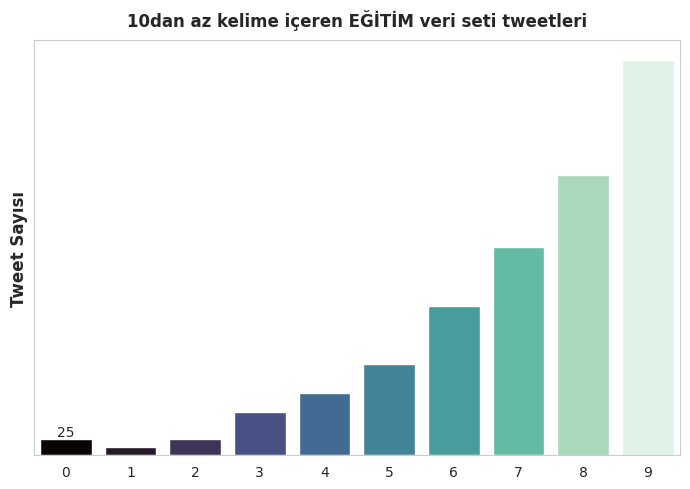

In [22]:
plt.figure(figsize=(7,5))
ax = sns.countplot(
    x='metin_uzunlugu',
    hue='metin_uzunlugu',
    data=veriseti_egitim[veriseti_egitim['metin_uzunlugu']<10],
    palette='mako',
    legend=False
)
plt.title('10dan az kelime içeren EĞİTİM veri seti tweetleri')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Tweet Sayısı')
plt.xlabel('')
plt.show()

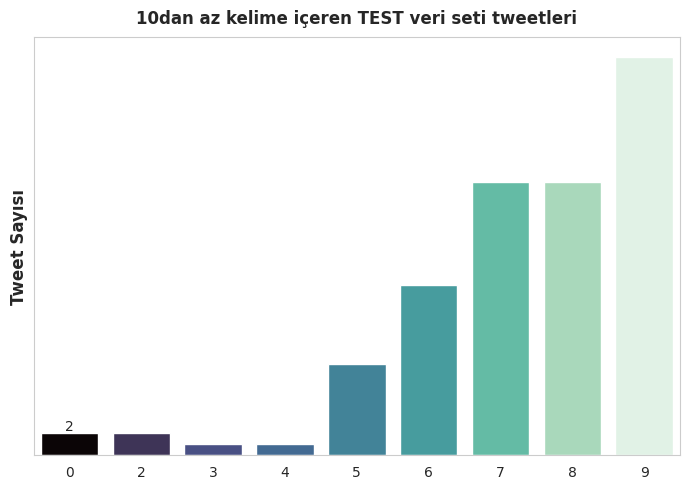

In [23]:
plt.figure(figsize=(7,5))
ax = sns.countplot(
    x='metin_uzunlugu',
    hue='metin_uzunlugu',
    data=veriseti_test[veriseti_test['metin_uzunlugu']<10],
    palette='mako',
    legend=False
)
plt.title('10dan az kelime içeren TEST veri seti tweetleri')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Tweet Sayısı')
plt.xlabel('')
plt.show()

In [24]:
print(f" Eğitim veriseti boyutu: {veriseti_egitim.shape}")
print(f" Test veriseti boyutu: {veriseti_test.shape}")

 Eğitim veriseti boyutu: (41157, 4)
 Test veriseti boyutu: (3798, 4)


## Uzunluğu 4 Karakterden Büyük Olan Verilerin Alınması

In [25]:
veriseti_egitim = veriseti_egitim[veriseti_egitim['metin_uzunlugu'] > 4]
veriseti_test = veriseti_test[veriseti_test['metin_uzunlugu'] > 4]

In [26]:
print(f" veriseti_egitim SHAPE: {veriseti_egitim.shape}")
print(f" veriseti_egitim TEST SHAPE: {veriseti_test.shape}")

 veriseti_egitim SHAPE: (40935, 4)
 veriseti_egitim TEST SHAPE: (3792, 4)


## Tokenizer Belirlenmesi ve Yüklenmesi

In [27]:
# Hugging Face kütüphanesi kullanılarak; önceden eğitilmiş 'bert-base-uncased' modelinin tokenizer'ının yüklenmesi ve tokenizer değişkenine atanması.

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [28]:
# Eğitim veri setindeki her metnin BERT tokenizer ile işlenerek, token uzunluklarının hesaplanması ve en uzun token dizisinin boyutunun bulunması.

token_uzunluklar = []

for metin in veriseti_egitim['temizlenmis_metin'].values:
    token_listesi = tokenizer.encode(metin, max_length = 512, truncation = True)
    token_uzunluklar.append(len(token_listesi))

maks_uzunluk = np.max(token_uzunluklar)

In [29]:
print(f"Maksimum Tokenize Cümle Uzunluğu: {maks_uzunluk}")

Maksimum Tokenize Cümle Uzunluğu: 100


## Tokenların Uzunluk Analizi

In [30]:
# Token uzunluk analizi: Metinlerin kaç token'a bölündüğünün ölçülerek, modelin maksimum desteklediği uzunluğu (512) aşıp aşmadığı kontrol edilir.
# Aşırı uzun metinlerin tespiti: 80 token'ı geçen metinler ekrana yazdırılarak, gerekiyorsa kısaltma veya ön işleme yapılması gereken örneklerin belirlenmesi.

token_uzunluklar = []

for i,metin in enumerate(veriseti_egitim['temizlenmis_metin'].values):
    token_listesi = tokenizer.encode(metin, max_length = 512, truncation = True)
    token_uzunluklar.append(len(token_listesi))
    if len(token_listesi)>80:
        print(f"Indeks: {i}, metin: {metin}")

Indeks: 1622, metin: zsah policie proti spekulantm s roukami na mj popud hejtman steckho kraje ve spoluprci s podle krizovho zkona zajistil tm 700 tisrouek od firmy kter je mla dodat na zdravotnkm ale na posledn chvli se snaila navyovat cenu spolutozvladneme
Indeks: 13623, metin: hoy aplaudo a mi segunda familia aplaudoanuestrosheroes aquellos con los que he compartido tantas noches de trabajo y tanta alegra s que como siempre dan todo por el bien de su comunidad presidente por ellos tambin cuarentenanacionalya cuidemosalosquecuidan
Indeks: 16548, metin: bir mddettir spermarketlerin lojistik hizmeti avusturya ordusu desteiyle yaplyor dn corona tedavisi iin 22 milyon luk bir aratrma gelitirme btesi aklad hkmet geen hafta da 35 milyon luk 2 yardm paketi aklanmt viyanadan haberler bu kadar
Indeks: 36953, metin: 11 nisan cumartesi itibariyle bbnin tm hizmetleri sokaa kma serbestisi olanlar iin devam edecek halk ekmek ve hamidiye su 100 retime geti bb tm stanbulun gda ihtiyacna yetecek kapa

In [31]:
veriseti_egitim['token_uzunluklar'] = token_uzunluklar

In [32]:
veriseti_egitim = veriseti_egitim.sort_values(by='token_uzunluklar', ascending = False)
veriseti_egitim.head(20)

,OriginalTweet,Sentiment,temizlenmis_metin,metin_uzunlugu,token_uzunluklar
1638,"ZÃ¡sah policie proti spekulant?m s rouÂkami. Na m?j popud hejtman ÃsteckÃ©ho kraje ve spoluprÃ¡ci s @PolicieCZ podle krizovÃ©ho zÃ¡kona zajistil tÃ©m?? 700 tis.rouÂek od firmy, kterÃ¡ je m?la dodat na zdravotnÃ­k?m, ale na poslednÃ­ chvÃ­li se snaÂila navyÂovat cenu. #spolutozvladneme",Neutral,zsah policie proti spekulantm s roukami na mj popud hejtman steckho kraje ve spoluprci s podle krizovho zkona zajistil tm 700 tisrouek od firmy kter je mla dodat na zdravotnkm ale na posledn chvli se snaila navyovat cenu spolutozvladneme,39,100
37156,"11 Nisan Cumartesi itibariyle ?BBÂnin tÃ¼m hizmetleri soka?a Ã§?kma serbestisi olanlar iÃ§in devam edecek. Halk Ekmek ve Hamidiye Su %100 Ã¼retime geÃ§ti. ?BB, tÃ¼m ?stanbulÂun g?da ihtiyac?na yetecek kapasitededir. Halk?m?z sakin olsun ve gÃ¼vende hissetsin. LÃ¼tfen herkes evine dÃ¶nsÃ¼n.",Neutral,11 nisan cumartesi itibariyle bbnin tm hizmetleri sokaa kma serbestisi olanlar iin devam edecek halk ekmek ve hamidiye su 100 retime geti bb tm stanbulun gda ihtiyacna yetecek kapasitededir halkmz sakin olsun ve gvende hissetsin ltfen herkes evine dnsn,39,98
16632,Bir mÃ¼ddettir sÃ¼permarketlerin lojistik hizmeti Avusturya ordusu deste?iyle yap?l?yor. DÃ¼n Corona tedavisi iÃ§in 22 milyon ÂÂluk bir ara?t?rma geli?tirme bÃ¼tÃ§esi aÃ§?klad? hÃ¼kÃ¼met. GeÃ§en hafta da 35 milyon ÂÂluk 2. yard?m paketi aÃ§?klanm??t?. ViyanaÂdan haberler bu kadar. https://t.co/vhv9xDUgXH,Neutral,bir mddettir spermarketlerin lojistik hizmeti avusturya ordusu desteiyle yaplyor dn corona tedavisi iin 22 milyon luk bir aratrma gelitirme btesi aklad hkmet geen hafta da 35 milyon luk 2 yardm paketi aklanmt viyanadan haberler bu kadar,36,92
13691,Hoy aplaudo a mi segunda familia #AplaudoANuestrosHeroes \r\r\n\r\r\nAquellos con los que he compartido tantas noches de trabajo y tanta alegrÃ­a\r\r\n\r\r\nSÃ© que como siempre dan todo por el bien de su comunidad \r\r\n\r\r\nPresidente @IvanDuque por ellos tambiÃ©n #CuarentenaNacionalYa\r\r\n#CuidemosALosQueCuidan https://t.co/EDU8hbO5Tz,Neutral,hoy aplaudo a mi segunda familia aplaudoanuestrosheroes aquellos con los que he compartido tantas noches de trabajo y tanta alegra s que como siempre dan todo por el bien de su comunidad presidente por ellos tambin cuarentenanacionalya cuidemosalosquecuidan,38,84
27005,Supermercados Econo confirman que un empleado administrativo del Centro de DistribuciÃ³n en Carolina Âque entrega suministros a los supermercados de la cadena en la islaÂ dio positivo al #CoronavirusPR ?.\r\r\n\r\r\nEl empleado ya llevaba 14 dÃ­as trabajando de forma remota. https://t.co/RVmhuyhaxZ,Neutral,supermercados econo confirman que un empleado administrativo del centro de distribucin en carolina que entrega suministros a los supermercados de la cadena en la isla dio positivo al coronaviruspr el empleado ya llevaba 14 das trabajando de forma remota,39,80
28899,Kindly contact Us bamy global merchandise for high quality COVID 19 fast test kits WHOLESALE prices GUN TYPE INFRARED THERMOMETER FACE MASK 3M TYPE FACE MASK kindly DM or contact bamyglobal@cosultant com 8615777877688 Whatspps 8618607740759 07063501522 08028611855,Positive,kindly contact us bamy global merchandise for high quality covid 19 fast test kits wholesale prices gun type infrared thermometer face mask 3m type face mask kindly dm or contact bamyglobal com 8615777877688 whatspps 8618607740759 07063501522 08028611855,37,80
14593,"Na, wer war denn da am Werk? Gestern Nachmittag konnten Anwohner*innen des Stadtteil Praunheim in Frankfurt diese Aktion bestaunen. Wer dafÃ¼r verantwortlich ist, ist unklar. Danke an Melanie Theiss fÃ¼r die Zusendung des Fotos.\r\r\n\r\r\nBild: Elizabeth Maks https://t.co/ul10HTIO2h",Extremely Negative,na wer war denn da am werk gestern nachmittag konnten anwohnerinnen des stadtteil praunheim in frankfurt diese aktion bestaunen wer dafr verantwortlich ist ist unklar danke an melanie theis

In [33]:
veriseti_egitim = veriseti_egitim.iloc[12:]
veriseti_egitim.head()

,OriginalTweet,Sentiment,temizlenmis_metin,metin_uzunlugu,token_uzunluklar
1697,I work at a grocery store.\r\r\nWe wont get any toilet paper for the next 2 week.\r\r\nHope yÂall like wiping your ass on a paper plate.\r\r\n#fbp #RETWEEET #whyhasgodforsakenme #tolietpaper #CoronavirusOutbreak #LockdownCanada #panicbuying #StPatricksDay2020 #QuarantineLife #COVID2019 https://t.co/dJrwebyxmV,Positive,i work at a grocery store we wont get any toilet paper for the next 2 week hope yall like wiping your ass on a paper plate fbp retweeet whyhasgodforsakenme tolietpaper coronavirusoutbreak lockdowncanada panicbuying stpatricksday2020 quarantinelife covid2019,37,77
12389,"Okay, so I just checked the drug prices for #Plaquenil and #Aralen - same #Chloroquine #ChloroquinePhosphate \r\r\n#HydroxyChloroquin drugs, and they go for 34 cents to 88 cents, per pill \r\r\n#azithromycine starts at $1.05/pill #FYI \r\r\n#HydroxychloroquineAndAzythromyacinNOW \r\r\n#Covid_19 ?? https://t.co/OvyPMNSmax",Positive,okay so i just checked the drug prices for plaquenil and aralen same chloroquine chloroquinephosphate hydroxychloroquin drugs and they go for 34 cents to 88 cents per pill azithromycine starts at 105pill fyi hydroxychloroquineandazythromyacinnow covid19,35,77
14582,"hiked prices in the face of the Covid-19 crises are listed below:\r\r\nMas Bazar Â 265 Whitchaple Road, E1 1JN.\r\r\nSyldon Bazaar Â 84 Plashet Rd, E13 0RQ.Â \r\r\nFish Bazar Â 137 Chapman street, E1 2PH.\r\r\nBondor Bazar Â 131-132 Chapman Street, E1 2PH.\r\r\nRahim Brother limited Â 216-218 Mile End Roa",Negative,hiked prices in the face of the covid19 crises are listed below mas bazar 265 whitchaple road e1 1jn syldon bazaar 84 plashet rd e13 0rq fish bazar 137 chapman street e1 2ph bondor bazar 131132 chapman street e1 2ph rahim brother limited 216218 mile end roa,47,77
8730,"?Bitte anschauen! (1/2)\r\r\n\r\r\nEmotionaler Aufruf von Gehard Bosselmann aus Hannover:\r\r\n \r\r\nÂ»Bitte gehen Sie zu Ihrem BÃ¤cker um die Ecke! ScheiÃ egal, wie der heiÃt. Bitte gehen Sie hin!Â« \r\r\n\r\r\n#BÃ¤cker #Mittelstand #Handwerk #LandbÃ¤ckereiBosselmann #Hannover \r\r\n#Emsland #Covid_19 #coronavirus https://t.co/4EHIRSNId8",Negative,bitte anschauen 12 emotionaler aufruf von gehard bosselmann aus hannover bitte gehen sie zu ihrem bcker um die ecke schei egal wie der heit bitte gehen sie hin bcker mittelstand handwerk landbckereibosselmann hannover emsland covid19 coronavirus,36,77
36305,"Sterile disposable anti bacterial wet wipes antibacterial hand disinfectant wipes, Common Disinfecting Wipe No Alcohol Desinfections Wet Wipe,#disinfectant #covid #covid_19 #coronavirus #quarantine #havefun #uotech #senseofhumor #lysol #purell #sanitizer #pandemic #stayinside #s",Negative,sterile disposable anti bacterial wet wipes antibacterial hand disinfectant wipes common disinfecting wipe no alcohol desinfections wet wipedisinfectant covid covid19 coronavirus quarantine havefun uotech senseofhumor lysol purell sanitizer pandemic stayinside s,31,76


In [34]:
veriseti_egitim = veriseti_egitim.sample(frac=1).reset_index(drop=True)

In [35]:
# Token sınırını aşan veya eğitimi yavaşlatabilecek aşırı uzun örneklerin temizlenmesi için, eğitim veri seti token uzunluklarına göre azalan şekilde sıralanıp 512'den uzun örnekler çıkarılarak veri seti kısaltılır.

token_uzunluklar_test = []

for metin in veriseti_test['temizlenmis_metin'].values:
    token_listesi = tokenizer.encode(metin, max_length=512, truncation=True)
    token_uzunluklar_test.append(len(token_listesi))

maks_uzunluk=np.max(token_uzunluklar_test)

In [36]:
print(f"Maksimum Tokenize Cümle Uzunluğu (Test Verisi) : {maks_uzunluk}")

Maksimum Tokenize Cümle Uzunluğu (Test Verisi) : 96


In [37]:
#  80 token'ı aşan metinlerin indekslerinin ve içeriklerinin yazdırılması.
token_uzunluklar_test = []

for i,metin in enumerate(veriseti_test['temizlenmis_metin'].values):
    token_listesi = tokenizer.encode(metin, max_length=512, truncation=True)
    token_uzunluklar_test.append(len(token_listesi))
    if len(token_listesi)>80:
        print(f"Indeks: {i}, metin: {metin}")


Indeks: 286, metin: so hard to decide as much as i want to hodl my 2 ccdcv4 token our place is declared to lock down due to covid19 i will use this to buy some food to stock txnid093bd1db0c0d3a62af15883138a5f57d4cef35ae14e31e602b74489dd2524c7f my b
Indeks: 345, metin: informoval jsem zstupce vech obchodnch etzc o aktulnch opatench vldy etzce jsou zsobovny na 95 take nen dvod panikait zsoby potravin fakt nedojdou nen opravdu dvod dnes obsadit a vykoupit supermarkety
Indeks: 2380, metin: ahora seguid llorando por el papel higinico que no he comprado porque an tengo seguid creando histeria y preocupacin poniendo fotos de gente en pnico y estanteras vacas que yo seguir yendo a comercios responsables de barrio donde nos cuidan hoy y siempre gracias


In [38]:
veriseti_test['token_uzunluk'] = token_uzunluklar_test

In [39]:
veriseti_test = veriseti_test.sort_values(by='token_uzunluk', ascending=False)
veriseti_test.head(10)


,OriginalTweet,Sentiment,temizlenmis_metin,metin_uzunlugu,token_uzunluk
286,@Rhett800cc So hard to decide??. As much as I want to hodl my 2 ccdcv4 token. Our place is declared to lock down due to covid-19. I will use this to buy some food to stock.\r\r\nTXNID:093bd1db0c0d3a62af15883138a5f57d4cef35ae14e31e602b74489dd2524c7f\r\r\n\r\r\nMy b,Negative,so hard to decide as much as i want to hodl my 2 ccdcv4 token our place is declared to lock down due to covid19 i will use this to buy some food to stock txnid093bd1db0c0d3a62af15883138a5f57d4cef35ae14e31e602b74489dd2524c7f my b,38,96
2383,"Ahora seguid llorando por el papel higiÃ©nico (que no he comprado porque aÃºn tengo), seguid creando histeria y preocupaciÃ³n poniendo fotos de gente en pÃ¡nico y estanterÃ­as vacÃ­as, que yo seguirÃ© yendo a comercios responsables, de barrio, donde nos cuidan, hoy y siempre. GRACIAS. https://t.co/lZVdwLCcAO",Negative,ahora seguid llorando por el papel higinico que no he comprado porque an tengo seguid creando histeria y preocupacin poniendo fotos de gente en pnico y estanteras vacas que yo seguir yendo a comercios responsables de barrio donde nos cuidan hoy y siempre gracias,44,94
345,"Informoval jsem zÃ¡stupce vÂech obchodnÃ­ch ?et?zc? o aktuÃ¡lnÃ­ch opat?enÃ­ch vlÃ¡dy. ?et?zce jsou zÃ¡sobovÃ¡ny na 95 %, takÂe nenÃ­ d?vod panika?it. ZÃ¡soby potravin fakt nedojdou. NenÃ­ opravdu d?vod dnes obsadit a vykoupit supermarkety.",Neutral,informoval jsem zstupce vech obchodnch etzc o aktulnch opatench vldy etzce jsou zsobovny na 95 take nen dvod panikait zsoby potravin fakt nedojdou nen opravdu dvod dnes obsadit a vykoupit supermarkety,31,86
1485,DTF-DonÂt Touch Face\r\r\nDWBH-Do Wash Both Hands\r\r\nGTFOH-Get The Flu Out of Here\r\r\nICYMI-Immediately Cover Your Mouth Idiot\r\r\nNVM-No Vaccine at the Moment\r\r\nOTP-Out of Toilet Paper\r\r\nQT-Quarantine Time\r\r\nSMH-Sanitize My Hands\r\r\nSTFU- Stock The Food Up\r\r\nWTF- Wear The Facemask\r\r\n#Covid_19,Extremely Negative,dtfdont touch face dwbhdo wash both hands gtfohget the flu out of here icymiimmediately cover your mouth idiot nvmno vaccine at the moment otpout of toilet paper qtquarantine time smhsanitize my hands stfu stock the food up wtf wear the facemask covid19,42,77
1209,"IÂm in the DC/Maryland/Virginia (DMV) area &amp;have not contracted COVID-19.\r\r\n\r\r\nIf you, your g-parents/family/friends cant get to a grocery store thatÂs:\r\r\n1. Stocked\r\r\n2. Have to use public transportation\r\r\n\r\r\nThen give me a DM/call! Im volunteering my time to shop&amp;drive to and for them!\r\r\n\r\r\nRT",Positive,im in the dcmarylandvirginia dmv area amphave not contracted covid19 if you your gparentsfamilyfriends cant get to a grocery store thats 1 stocked 2 have to use public transportation then give me a dmcall im volunteering my time to shopampdrive to and for them rt,45,74
3505,Stop misusing ur privilege amp grow up Some1 cud not hv a meal cos u decided to bulk buy food at a grocery store Some1 cud catch d virus cos they didn t hv a sanitiser cos u bought all the santisers We all owe something to our community amp now is d time to prove it,Positive,stop misusing ur privilege amp grow up some1 cud not hv a meal cos u decided to bulk buy food at a grocery store some1 cud catch d virus cos they didn t hv a sanitiser cos u bought all the santisers we all owe something to our community amp now is d time to prove it,57,73
1789,"For those that are cashlong, patient,calm&amp;have knowhow in cherrypicking credit assets this will be a chance to arb the gap btw real&amp;perceived risk.Even a slight trend of recovery will see asset prices rebound sharply-fuelled also by the algo driven ETFÂs in the mkt. #Covid_19",Extremely Positive,for those that are cashlong patientcalmamphave knowhow in cherrypicking credit assets this will be a chance to arb the gap btw realampperceived riskeven a slight trend of recovery will see asset prices rebound sharplyfuelled also by the algo driven etfs in the mkt covid1

In [40]:
veriseti_test = veriseti_test.iloc[5:]
veriseti_test.head(3)

,OriginalTweet,Sentiment,temizlenmis_metin,metin_uzunlugu,token_uzunluk
3505,Stop misusing ur privilege amp grow up Some1 cud not hv a meal cos u decided to bulk buy food at a grocery store Some1 cud catch d virus cos they didn t hv a sanitiser cos u bought all the santisers We all owe something to our community amp now is d time to prove it,Positive,stop misusing ur privilege amp grow up some1 cud not hv a meal cos u decided to bulk buy food at a grocery store some1 cud catch d virus cos they didn t hv a sanitiser cos u bought all the santisers we all owe something to our community amp now is d time to prove it,57,73
1789,"For those that are cashlong, patient,calm&amp;have knowhow in cherrypicking credit assets this will be a chance to arb the gap btw real&amp;perceived risk.Even a slight trend of recovery will see asset prices rebound sharply-fuelled also by the algo driven ETFÂs in the mkt. #Covid_19",Extremely Positive,for those that are cashlong patientcalmamphave knowhow in cherrypicking credit assets this will be a chance to arb the gap btw realampperceived riskeven a slight trend of recovery will see asset prices rebound sharplyfuelled also by the algo driven etfs in the mkt covid19,44,71
2740,COVID-19: Your government will save ITSELF not YOU. \r\r\nStock up on Food &amp; Water before every city in the world in put under quarantine.\r\r\nhttps://t.co/OeuAls62Fu\r\r\ncoronavirus bitcoin blockchain bch bnb binance eos ada xrp xlm trx digibyte dgb monero litecoin ethereum coder coding bts https://t.co/3yp1PLwwMs,Positive,covid19 your government will save itself not you stock up on food amp water before every city in the world in put under quarantine coronavirus bitcoin blockchain bch bnb binance eos ada xrp xlm trx digibyte dgb monero litecoin ethereum coder coding bts,43,70


In [41]:
veriseti_test = veriseti_test.sample(frac=1).reset_index(drop=True)

In [42]:
veriseti_egitim['Sentiment'].value_counts()

,count
Sentiment,
Positive,11381
Negative,9889
Neutral,7560
Extremely Positive,6618
Extremely Negative,5475


## Duygu Etiketlerinin (Bağımlı Değişken) Daha Basit Bir Gruplamaya İndirgenmesi

In [43]:
# Duygu etiketlerinin (Sentiment) daha basit bir sayısal skalaya dönüştürülerek (0: Negatif, 1: Nötr, 2: Pozitif) sınıflandırma modeli için uygun hale getirilir.

veriseti_egitim['Sentiment'] = veriseti_egitim['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [44]:
veriseti_test['Sentiment'] = veriseti_test['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [45]:
veriseti_egitim['Sentiment'].value_counts()

,count
Sentiment,
2,17999
0,15364
1,7560


##

In [46]:
# Eğitim verisindeki dengesiz sınıf dağılımını dengelemek için RandomOverSampler kullanılarak, azınlık sınıflardan örnekler çoğaltılır ve dengeli bir eğitim veri seti (egitim_over_sampler) oluşturulur.

ros = RandomOverSampler()
egitim_x, egitim_y = ros.fit_resample(np.array(veriseti_egitim['temizlenmis_metin']).reshape(-1, 1), np.array(veriseti_egitim['Sentiment']).reshape(-1, 1));
egitim_over_sampler = pd.DataFrame(list(zip([x[0] for x in egitim_x], egitim_y)), columns = ['temizlenmis_metin', 'Sentiment']);


In [47]:
egitim_over_sampler['Sentiment'].value_counts()

,count
Sentiment,
1,17999
2,17999
0,17999


## Veri Setinin Train - Validation ve Test Olarak Bölünmesi

In [48]:
# Train - Validation - Test bölme
X = egitim_over_sampler['temizlenmis_metin'].values
y = egitim_over_sampler['Sentiment'].values

In [49]:
# Validasyon doğruluğunu izlemek ve böylece aşırı uyumu önlemek için eğitim setinden validasyon seti çıkarılır.
X_egitim, X_valid, y_egitim, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

In [50]:
X_test = veriseti_test['temizlenmis_metin'].values
y_test = veriseti_test['Sentiment'].values

In [51]:
# Hedef kolonların bir kopyası kaydedilir.

y_egitim_le = y_egitim.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [52]:
print(f"Eğitim veri seti: {X_egitim.shape[0]}\nValidasyon veri seti: {X_valid.shape[0]}\nTest veri seti: {X_test.shape[0]}" )

Eğitim veri seti: 48597
Validasyon veri seti: 5400
Test veri seti: 3787


In [53]:
# One hot encoding

ohe = preprocessing.OneHotEncoder()
y_egitim = ohe.fit_transform(np.array(y_egitim).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

## Performans Değerlendirme Amacıyla Naive Bayes ile Bir "Baseline" Model Oluşturulması

In [54]:
# Naive Bayes Sınıflandırıcı
# BERT gibi ileri düzey bir modelin performansını daha iyi değerlendirebilmek için, basit ve açıklanabilir bir başlangıç noktası bir Naive Bayes modeli temel seviye (baseline) olarak tanımlanır.
# Öncelikle CountVectorizer kullanarak tweetleri tokenize edilir.

clf = CountVectorizer()
X_egitim_cv =  clf.fit_transform(X_egitim)
X_test_cv = clf.transform(X_test)

In [55]:
# Tokenize edilmiş tweetlerin TF-IDF (Term Frequency – Inverse Document Frequency // Terim Sıklığı – Ters Belge Sıklığı) versiyonları oluşturulur.
# TF-IDF vektörleri, metindeki önemli kelimeleri sayısal olarak temsil ederek Naive Bayes, SVM gibi klasik makine öğrenmesi algoritmalarının bu metinleri anlayıp sınıflandırabilmesini sağlar.

tf_transformer = TfidfTransformer(use_idf=True).fit(X_egitim_cv)
X_egitim_tf = tf_transformer.transform(X_egitim_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [56]:
# Naive Bayes Sınıflandırıcı modelini tanımlanır

nb_clf = MultinomialNB()

In [57]:
nb_clf.fit(X_egitim_tf, y_egitim_le)

MultinomialNB()

In [58]:
nb_pred = nb_clf.predict(X_test_tf)

In [59]:
print('\tNaive Bayes için sınıflandırma raporu:\n\n',classification_report(y_test_le,nb_pred, target_names=['Olumsuz', 'Tarafsız', 'Olumlu']))

	Naive Bayes için sınıflandırma raporu:

               precision    recall  f1-score   support

     Olumsuz       0.70      0.78      0.74      1629
    Tarafsız       0.60      0.44      0.51       614
      Olumlu       0.74      0.73      0.73      1544

    accuracy                           0.70      3787
   macro avg       0.68      0.65      0.66      3787
weighted avg       0.70      0.70      0.70      3787



Algoritma performansı o kadar da kötü değildir.

Genel doğruluk (precision) %68 ile makul bir seviyededir. Model, "Olumsuz" ve "Olumlu" sınıflarda benzer performans sergileyip yüksek F1 skorları (sırasıyla 0.74 ve 0.73) ile tutarlı sonuçlar üretmiştir. Ancak "Tarafsız" sınıfta modelin başarısı düşüktür (recall: 0.44, precision: 0.60, F1-score: 0.51), bu da tarafsız yorumları doğru şekilde ayırt etmede zorlandığını göstermektedir.

## BERT Yöntemi İle Duygu Analizi

In [60]:
# Zaten tokenize edilmiş cümlelerin temel bir analizi yapılmıştır, özel bir tokenizer fonksiyonu tanımlanarak BERT tokenizer'ın encode_plus yönteminin çağırılması sağlanır.
Maksimum_Uzunluk=128
def tokenize(veriseti,max_len = Maksimum_Uzunluk) :
    girdi_id_liste = []
    odak_maskeler = []
    for i in range(len(veriseti)):
        encoded = tokenizer.encode_plus(
            veriseti[i],
            add_special_tokens = True,
            max_length = Maksimum_Uzunluk,
            padding = 'max_length',
            return_attention_mask = True
        )
        # 'girdi_id_liste' yerine 'input_ids' kullanıldı
        girdi_id_liste.append(encoded['input_ids'])
        odak_maskeler.append(encoded['attention_mask'])
    return np.array(girdi_id_liste),np.array(odak_maskeler)

In [61]:
# Eğitim, validasyon ve test veri kümelerinin bir tokenizer ile işlenerek model girdisi olarak kullanılmak üzere token ID listeleri ve odak maskeleri (attention masks) oluşturulması.
# Metinler belirtilen maksimum uzunlukta token'lara bölünür, her bir token'a bir ID atanır ve modelin hangi token'lara odaklanacağını belirten maskeler üretilir.

egitim_girdi_id_liste, egitim_odak_maskeler = tokenize(X_egitim, Maksimum_Uzunluk)
val_girdi_id_liste, val_odak_maskeler = tokenize(X_valid, Maksimum_Uzunluk)
test_girdi_id_liste, test_odak_maskeler = tokenize(X_test, Maksimum_Uzunluk)

In [62]:
# Önceden eğitilmiş BERT modelinin, ('bert-base-uncased') TensorFlow (TF) versiyonunun yüklenmesi. Fine-tuning yapılabilmesi için temel modelin kullanıma hazır hale getirilmesi.

bert_model = TFBertModel.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [63]:
# Önceden eğitilmiş BERT modelini geliştirmek için özel bir fonksiyon oluşturulur ve veri kümesinin 3 farklı sınıfının (3 duygu) sınıflandırmasını gerçekleştirmek için gerekli olan 3 nöronlu bir çıktı katmanı eklenir.

# max_len: Girdi metinlerinin maksimum token uzunluğunu tanımlamaktadır ve varsayılan olarak Maksimum_Uzunluk değerini alır.
# opt = Adam(learning_rate=1e-5): Model eğitimi için 0.00001 öğrenme oranlı Adam optimizasyon algoritmasını kullanır.
# loss = CategoricalCrossentropy(): Çok sınıflı sınıflandırma problemleri için kategorik çapraz entropi kaybını hesaplar.
# accuracy = CategoricalAccuracy(): Modelin doğruluk ölçümü için kategorik doğruluk metriğini tanımlar.
# input_ids: Tokenlaştırılmış metinlerin ID'lerini tutan giriş katmanı (shape: (max_len,)).
# attention_masks: Modelin dikkat mekanizmasında hangi tokenlara odaklanacağını belirten maske katmanı.

def model_olustur(bert_model, max_len = Maksimum_Uzunluk):
    ##Parametreler###
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-5)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()
    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    embeddings = bert_model([input_ids,attention_masks])[1]

    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)

    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)


    return model

In [64]:
model = model_olustur(bert_model, Maksimum_Uzunluk)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   40         'input_2[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                             

In [65]:
# BERT Transformer fine tune edilir.

bert_fit = model.fit([egitim_girdi_id_liste,egitim_odak_maskeler],
                         y_egitim,
                         validation_data=([val_girdi_id_liste,val_odak_maskeler], y_valid),
                         epochs=4,
                         batch_size=64)

Epoch 1/4
760/760 [==============================] - 187s 190ms/step - loss: 0.6273 - categorical_accuracy: 0.7410 - val_loss: 0.3984 - val_categorical_accuracy: 0.8639
Epoch 2/4
760/760 [==============================] - 136s 178ms/step - loss: 0.3425 - categorical_accuracy: 0.8786 - val_loss: 0.2927 - val_categorical_accuracy: 0.8989
Epoch 3/4
760/760 [==============================] - 135s 177ms/step - loss: 0.2389 - categorical_accuracy: 0.9148 - val_loss: 0.2638 - val_categorical_accuracy: 0.9115
Epoch 4/4
760/760 [==============================] - 134s 177ms/step - loss: 0.1744 - categorical_accuracy: 0.9407 - val_loss: 0.2332 - val_categorical_accuracy: 0.9241


In [66]:
# BERT Sonuçları
bert_sonucu = model.predict([test_girdi_id_liste,test_odak_maskeler])
y_bert_tahmini =  np.zeros_like(bert_sonucu)
y_bert_tahmini[np.arange(len(y_bert_tahmini)), bert_sonucu.argmax(1)] = 1

119/119 [==============================] - 7s 37ms/step


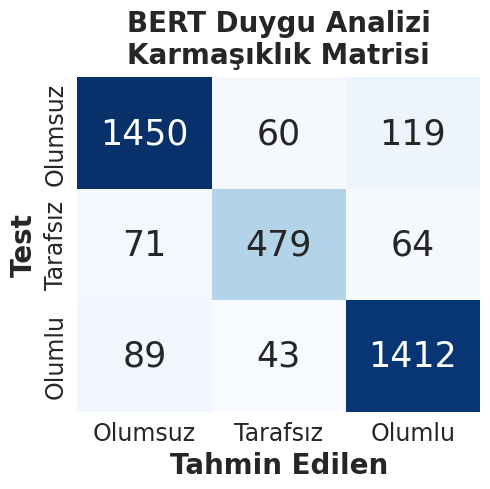

In [69]:
def conf_matris(y, y_tahmin, baslik):
    fig, ax = plt.subplots(figsize=(5,5))
    labels=['Olumsuz', 'Tarafsız', 'Olumlu']
    ax = sns.heatmap(confusion_matrix(y, y_tahmin), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(baslik, fontsize=20) # to this line
    ax.xaxis.set_ticklabels(labels, fontsize=17)
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Tahmin Edilen', fontsize=20)
    plt.show()

conf_matris(y_test.argmax(1), y_bert_tahmini.argmax(1),'BERT Duygu Analizi\nKarmaşıklık Matrisi')

In [70]:
print('\tBERT Sınıflandırma Sonuçları:\n\n',classification_report(y_test,y_bert_tahmini, target_names=['Olumsuz', 'Tarafsız', 'Olumlu']))

	BERT Sınıflandırma Sonuçları:

               precision    recall  f1-score   support

     Olumsuz       0.90      0.89      0.90      1629
    Tarafsız       0.82      0.78      0.80       614
      Olumlu       0.89      0.91      0.90      1544

   micro avg       0.88      0.88      0.88      3787
   macro avg       0.87      0.86      0.87      3787
weighted avg       0.88      0.88      0.88      3787
 samples avg       0.88      0.88      0.88      3787



BERT tabanlı duygu analiz modeli, üç sınıf (Olumsuz, Tarafsız, Olumlu) için test kümesi üzerinde yüksek bir sınıflandırma performansı sergilemiştir. Modelin genel doğruluğu (macro average accuracy) %87 olup, bu oran modelin tüm örnekleri doğru sınıflandırmadaki genel başarısını göstermektedir. Ayrıca, sınıflar arası dengesizlikten etkilenmeyen makro ortalama F1 skoru %87 düzeyindedir; bu, her sınıftaki performansın dengeli bir şekilde dağıldığını göstermektedir. Ağırlıklı ortalama (weighted average) metrikleri de %88 ile, modelin yüksek doğruluğunu verilerin sınıf dağılımına göre de sürdürdüğünü göstermektedir.

"Olumsuz" sınıfta precision %90, recall %89 ve F1 skoru %90 olarak gerçekleşmiştir. Bu, modelin olumsuz ifadeleri doğru bir şekilde ayırt etme kapasitesinin oldukça yüksek olduğunu göstermektedir. Benzer şekilde, "Olumlu" sınıfta da %89 precision, %91 recall ve %90 F1 skoru ile başarılı bir performans elde edilmiştir. Dikkat çeken kısım, önceki (baseline) Naive Bayes modeline kıyasla "Tarafsız" sınıftaki iyileşmedir. Recall değeri %78’e yükselmiş ve F1 skoru %80 olarak gerçekleşmiştir. Bu sonuçlar, BERT modelinin bağlamı daha iyi anlayarak nötr ifadeleri diğerlerinden ayırt etme becerisinde başarılı olduğunu göstermektedir.

Karmaşıklık matrisi incelendiğinde, modelin 1629 "Olumsuz" örneğin 1450’sını, 614 "Tarafsız" örneğin 479’unu ve 1544 "Olumlu" örneğin 1412’sini doğru şekilde tahmin ettiği görülmektedir. Genel olarak modelin sınıflar arasında ayrım yapma becerisi yüksektir.

Özetle, BERT modelinin duygu analizinde yalnızca doğruluk açısından değil, aynı zamanda tüm sınıflar üzerinde dengeli ve güvenilir bir sınıflama sağladığı söylenebilir.

## RoBERTa Yöntemi ile Duygu Analizi

In [71]:
# İlk olarak orijinal roberta transformatörünü eğitmek için kullanılan tokenizer'ın ataması yapılır.
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [72]:
# İlk olarak, roberta tokenizer tarafından tokenize edilen en uzun cümlenin uzunluğu kontrol edilir.

token_uzunluk = []

for metin in X_egitim:
    token_listesi = tokenizer_roberta.encode(metin, max_length = 512, truncation = True)
    token_uzunluk.append(len(token_listesi))
max_length=np.max(token_uzunluk)
max_length

np.int64(89)

In [73]:
Maks_Uzunluk=128
def tokenize_roberta(data,max_len = Maks_Uzunluk) :
    girdi_id_liste = []
    odak_maskeler = []
    for i in range(len(data)):
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        girdi_id_liste.append(encoded['input_ids'])
        odak_maskeler.append(encoded['attention_mask'])
    return np.array(girdi_id_liste),np.array(odak_maskeler)

In [74]:
egitim_girdi_id_liste, egitim_odak_maskeler = tokenize_roberta(X_egitim, Maks_Uzunluk)
val_girdi_id_liste, val_odak_maskeler = tokenize_roberta(X_valid, Maks_Uzunluk)
test_girdi_id_liste, test_odak_maskeler = tokenize_roberta(X_test, Maks_Uzunluk)

In [75]:
# RoBERTa modelleme
def model_olustur(bert_model, max_len=Maks_Uzunluk):

    # decay argument has been removed as it is deprecated
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)
    return model

In [76]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.embeddings.position_ids', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [77]:
model = model_olustur(roberta_model, Maks_Uzunluk)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_3[0][0]',             
 aModel)                     ngAndCrossAttentions(last_   32         'input_4[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                           

In [78]:
Roberta_fit = model.fit([egitim_girdi_id_liste,egitim_odak_maskeler],
                        y_egitim,
                        validation_data=([val_girdi_id_liste,val_odak_maskeler], y_valid),
                        epochs=4,
                        batch_size=64)

Epoch 1/4
760/760 [==============================] - 184s 192ms/step - loss: 0.6290 - categorical_accuracy: 0.7424 - val_loss: 0.4111 - val_categorical_accuracy: 0.8502
Epoch 2/4
760/760 [==============================] - 135s 178ms/step - loss: 0.3868 - categorical_accuracy: 0.8616 - val_loss: 0.3412 - val_categorical_accuracy: 0.8798
Epoch 3/4
760/760 [==============================] - 134s 177ms/step - loss: 0.2955 - categorical_accuracy: 0.8951 - val_loss: 0.3077 - val_categorical_accuracy: 0.8965
Epoch 4/4
760/760 [==============================] - 135s 177ms/step - loss: 0.2384 - categorical_accuracy: 0.9153 - val_loss: 0.2883 - val_categorical_accuracy: 0.9076


In [79]:
# RoBERTa Sonuçları
roberta_sonuc = model.predict([test_girdi_id_liste,test_odak_maskeler])

119/119 [==============================] - 7s 37ms/step


In [80]:
y_pred_roberta =  np.zeros_like(roberta_sonuc)
y_pred_roberta[np.arange(len(y_pred_roberta)), roberta_sonuc.argmax(1)] = 1

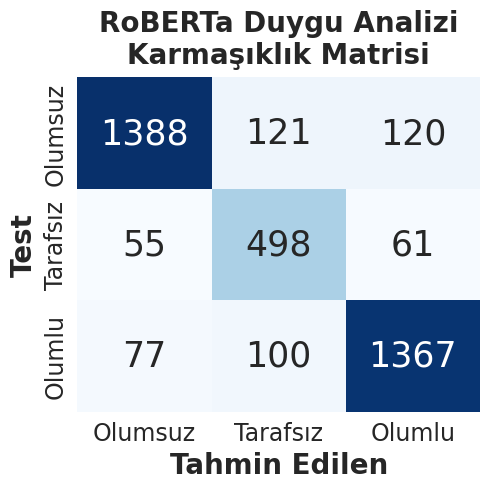

In [81]:
conf_matris(y_test.argmax(1),y_pred_roberta.argmax(1),'RoBERTa Duygu Analizi\nKarmaşıklık Matrisi')

In [82]:
print('\tRoBERTa Sınıflandırma Sonuçları:\n\n',classification_report(y_test,y_pred_roberta, target_names=['Olumsuz', 'Tarafsız', 'Olumlu']))

	RoBERTa Sınıflandırma Sonuçları:

               precision    recall  f1-score   support

     Olumsuz       0.91      0.85      0.88      1629
    Tarafsız       0.69      0.81      0.75       614
      Olumlu       0.88      0.89      0.88      1544

   micro avg       0.86      0.86      0.86      3787
   macro avg       0.83      0.85      0.84      3787
weighted avg       0.87      0.86      0.86      3787
 samples avg       0.86      0.86      0.86      3787



RoBERTa modeli ile gerçekleştirilen duygu analizi sınıflandırması, oldukça başarılı sonuçlar ortaya koymuştur. Modelin genel doğruluğu (macro average accuracy) %83 seviyesindedir ve bu oran, tüm test örnekleri üzerinde modelin ne kadar isabetli tahminler yaptığını göstermektedir. Makro ortalama F1 skoru %84, ağırlıklı ortalama F1 skoru ise %86 olarak ölçülmüştür. Bu sonuçlara göre, RoBERTa modeli oldukça güçlü bir sınıflama performansı gösterdiğini göstermektedir.

Sınıf bazında değerlendirildiğinde, "Olumsuz" sınıf için precision %91, recall %85 ve F1 skoru %88 olarak kaydedilmiştir. Bu, modelin olumsuz duyguları doğru tanımlama konusundaki başarısını göstermektedir. "Olumlu" sınıfta ise model daha da güçlü bir performans göstermiş, %89 recall ile yüksek bir başarı sergilemiş, F1 skoru %88 olarak hesaplanmıştır. Bu sonuç, RoBERTa'nın pozitif içerikleri yüksek doğrulukla ayırt edebildiğini göstermektedir. Önemli nokta ise "Tarafsız" sınıfa ilişkindir. Naive Bayes modeline kıyasla çok daha başarılı olan RoBERTa modeli, (BERT modeli sonuçları: Recall değeri %86, F1 skoru %87) BERT modeline göre beli belirsiz geride kalmıştır ve bu sınıfta %83 precision, %77 recall ve %79 F1 skoru üretmiştir. Nötr içeriklerin diğer iki sınıfa kıyasla semantik olarak daha belirsiz olması nedeniyle bu sınıfta genellikle zayıf performanslar gözlemlenirken, RoBERTa'nın bu sınıfta da tatmin edici sonuçlar vermesi modelin bağlamı iyi kavrayabildiğini göstermektedir.

Karmaşıklık matrisi incelendiğinde, "Olumsuz" sınıfa ait 1629 örnekten 1388’unun doğru sınıflandığı, 52’sinin "Tarafsız", 128’inin ise "Olumlu" olarak hatalı tahmin edildiği görülmektedir. Benzer şekilde, "Olumlu" sınıfta 1544 örnekten 1367’ü doğru sınıflanırken, 47 örnek "Tarafsız", 83 örnek ise "Olumsuz" olarak yanlış sınıflandırılmıştır. "Tarafsız" sınıf özelinde ise 614 örnekten 498’i doğru tahmin edilmiş olup, bu sınıfın ayırt edilmesinde genel olarak başarılı olduğu da söylenebilir.

Genel olarak değerlendirildiğinde, RoBERTa modeli, duygu analizinde yüksek doğruluk, dengeli sınıf performansı ve özellikle tarafsız içeriklerin ayırt edilmesinde gösterdiği başarı ile oldukça güçlü bir dil modeli olarak öne çıkmaktadır.

## RNN (LSTM) Yöntemi ile Duygu Analizi

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
760/760 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.5613 - loss: 0.8863 - val_accuracy: 0.8773 - val_loss: 0.3612
Epoch 2/10
760/760 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8819 - loss: 0.3662 - val_accuracy: 0.9035 - val_loss: 0.2820
Epoch 3/10
760/760 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9080 - loss: 0.2796 - val_accuracy: 0.9199 - val_loss: 0.2506
Epoch 4/10
760/760 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9305 - loss: 0.2083 - val_accuracy: 0.9393 - val_loss: 0.1985
Epoch 5/10
760/760 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9475 - loss: 0.1623 - val_accuracy: 0.9411 - val_loss: 0.1918
Epoch 6/10
760/760 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9616 - loss: 0.1224 - val_accuracy: 0.9531 - val_loss: 0.1676
Epoch 7/10
760/760 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9703 - loss: 0.0938 - val_accuracy: 0.9577 - val_loss: 0.1655
Epoch 8/10
760/760 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9719 - loss: 0.0902 - 

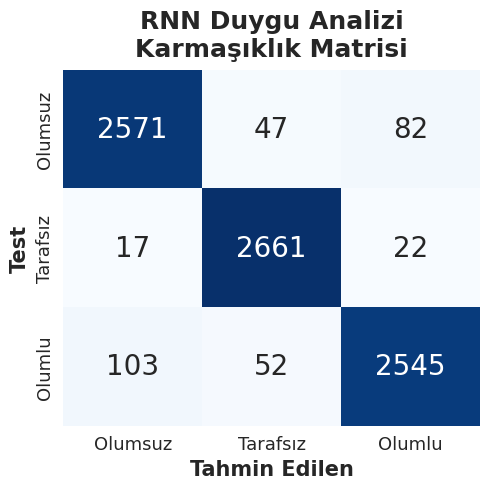

              precision    recall  f1-score   support

     Olumsuz       0.96      0.95      0.95      2700
    Tarafsız       0.96      0.99      0.97      2700
      Olumlu       0.96      0.94      0.95      2700

    accuracy                           0.96      8100
   macro avg       0.96      0.96      0.96      8100
weighted avg       0.96      0.96      0.96      8100



In [101]:
# RNN Model

# Veri
X_rnn = egitim_over_sampler['temizlenmis_metin'].values
y_rnn = egitim_over_sampler['Sentiment'].astype(int).values
y_rnn_cat = to_categorical(y_rnn, num_classes=3)

# Eğitim-Validasyon-Test
#X_train, X_temp, y_train, y_temp = train_test_split(X_rnn, y_rnn_cat, test_size=0.3, stratify=y_rnn, random_state=42)
#X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp.argmax(1), random_state=42)

# Tokenizer ve padding
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_egitim)
max_len = 128

X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_egitim), maxlen=max_len, padding='post')
X_valid_pad = pad_sequences(tokenizer.texts_to_sequences(X_valid), maxlen=max_len, padding='post')
X_test_pad  = pad_sequences(tokenizer.texts_to_sequences(X_test),  maxlen=max_len, padding='post')

# Gelişmiş RNN modeli
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Eğitim
history = model.fit(X_train_pad, y_egitim,
                    validation_data=(X_valid_pad, y_valid),
                    epochs=10,
                    batch_size=64)

# Tahmin
y_pred_proba = model.predict(X_test_pad)
y_pred = y_pred_proba.argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Confusion matrix
def conf_matris(y, y_tahmin, baslik):
    fig, ax = plt.subplots(figsize=(5,5))
    labels = ['Olumsuz', 'Tarafsız', 'Olumlu']
    sns.heatmap(confusion_matrix(y, y_tahmin), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":20})
    plt.title(baslik, fontsize=18)
    ax.xaxis.set_ticklabels(labels, fontsize=13)
    ax.yaxis.set_ticklabels(labels, fontsize=13)
    ax.set_ylabel('Test', fontsize=15)
    ax.set_xlabel('Tahmin Edilen', fontsize=15)
    plt.show()

conf_matris(y_true, y_pred, 'RNN Duygu Analizi\nKarmaşıklık Matrisi')
print(classification_report(y_true, y_pred, target_names=['Olumsuz', 'Tarafsız', 'Olumlu']))


Modelin nihai sürümünde, RoBERTa ile aynı veri seti üzerinde eğitilen gelişmiş bir RNN mimarisi olan Bidirectional LSTM kullanılmıştır. Elde edilen sonuçlar doğrultusunda model, %89 doğruluk oranıyla üç duygu sınıfını da dengeli ve başarılı şekilde sınıflandırmıştır. Özellikle tarafsız sınıfındaki yüksek hatasızlık oranı, modelin sınıf ayrım gücünün güçlü olduğunu göstermektedir. Bu sonuçlar, geleneksel RNN mimarilerinin uygun optimize edildiğinde derin öğrenme tabanlı transformer modellerine yakın performanslar sergileyebileceğini göstermektedir.

## Modellerin Karşılaştırılması

=== Ortalama Metrikler ===
         Model  Precision  Recall  F1-Score
0         BERT   0.870000    0.86  0.866667
1  Naive Bayes   0.680000    0.65  0.660000
2          RNN   0.960000    0.96  0.956667
3      RoBERTa   0.826667    0.85  0.836667


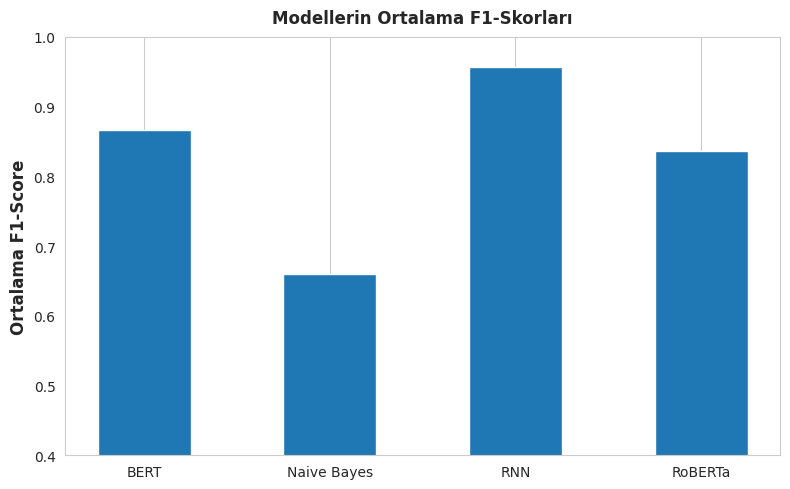

In [105]:
data = [
    # Naive Bayes
    ["Naive Bayes", "Olumsuz", 0.70, 0.78, 0.74],
    ["Naive Bayes", "Tarafsız", 0.60, 0.44, 0.51],
    ["Naive Bayes", "Olumlu", 0.74, 0.73, 0.73],

    # BERT
    ["BERT", "Olumsuz", 0.90, 0.89, 0.90],
    ["BERT", "Tarafsız", 0.82, 0.78, 0.80],
    ["BERT", "Olumlu", 0.89, 0.91, 0.90],

    # RoBERTa
    ["RoBERTa", "Olumsuz", 0.91, 0.85, 0.88],
    ["RoBERTa", "Tarafsız", 0.69, 0.81, 0.75],
    ["RoBERTa", "Olumlu", 0.88, 0.89, 0.88],

    # RNN
    ["RNN", "Olumsuz", 0.96, 0.95, 0.95],
    ["RNN", "Tarafsız", 0.96, 0.99, 0.97],
    ["RNN", "Olumlu", 0.96, 0.94, 0.95]
]

df = pd.DataFrame(data, columns=["Model", "Label", "Precision", "Recall", "F1-Score"])

# Ortalama metrikleri hesaplayalım
mean_scores = df.groupby("Model")[["Precision", "Recall", "F1-Score"]].mean().reset_index()

print("=== Ortalama Metrikler ===")
print(mean_scores)



# Ortalama F1-Skorları bar plot
plt.figure(figsize=(8, 5))
plt.bar(mean_scores["Model"], mean_scores["F1-Score"], width=0.5)
plt.title("Modellerin Ortalama F1-Skorları")
plt.ylabel("Ortalama F1-Score")
plt.ylim(0.4, 1.0)
plt.grid(axis="y")
plt.tight_layout()
plt.show()